In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as pt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bostonhoustingmlnd/housing.csv


# Importing data (Boston Housing Data to predict house prices)
1. Link - https://www.kaggle.com/schirmerchad/bostonhoustingmlnd

In [2]:
input_ads = pd.read_csv('../input/bostonhoustingmlnd/housing.csv')

#-----------------------------------------------------------------
#Summary
print(input_ads.shape)
input_ads.head()

(489, 4)


,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


# Null Check

In [3]:
input_ads.isnull().sum()

RM         0
LSTAT      0
PTRATIO    0
MEDV       0
dtype: int64

# Description of the target variable

In [4]:
input_ads['MEDV'].describe()

count    4.890000e+02
mean     4.543429e+05
std      1.653403e+05
min      1.050000e+05
25%      3.507000e+05
50%      4.389000e+05
75%      5.187000e+05
max      1.024800e+06
Name: MEDV, dtype: float64

# Data Splitting & Pre-Processing 

In [5]:
#Splitting of the ADS into X and Y components
X = input_ads[[cols for cols in list(input_ads.columns) if 'MEDV' not in cols]]
y = input_ads['MEDV']

#Train-test split creation
X, X_test, y, y_test = train_test_split(X, y, test_size=0.30, random_state=100)

#--------------------------------------------------------------------------------
#Scaling the datasets
scaler = StandardScaler()

X_arr = scaler.fit_transform(X)
X_test_arr = scaler.fit_transform(X_test)

y_arr = np.array(y).reshape(X_arr.shape[0],1)
y_test_arr = np.array(y_test).reshape(X_test_arr.shape[0],1)

#--------------------------------------------------------------------------------
#Summary
print('Training x rows :',X_arr.shape)
print('Testing x rows :',X_test_arr.shape)
print('Training y rows :',y_arr.shape)

Training x rows : (342, 3)
Testing x rows : (147, 3)
Training y rows : (342, 1)


# Linear Regression from scratch

### Defining fwd prop UDF, Cost function UDF & initiating weights and intercepts

In [6]:
#For forward propagation in the model
def fwd_prop(X_arr,w,b):
    
    a = np.dot(X_arr,w) + b
    #print('Shape of a:',a.shape)
    
    return a

#Cost function as per regularization
def cost_fn(y_true,y_pred,n_examples,reg_alpha,reg_type,w_):
    
    if reg_type=='L1':
        reg = np.sum(abs(w_))
    elif reg_type=='L2':
        reg = 0.5 * np.sum(np.square(w_))
    
    cost = (1/(2*n_examples)) * np.sum(np.square(y_pred-y_true)) + (reg_alpha*reg)
    #print('Cost :',cost)
    return cost    

#Setting seed
np.random.seed(100)

#Initializing weights(w) and bias(b) vectors 
#-------------------------------------------
w = np.random.rand(X.shape[1],1)
print(w)
#-------------------------------------------
b = np.zeros(1)
b

[[0.54340494]
 [0.27836939]
 [0.42451759]]


array([0.])

## UDF for batch_gradient_descent
#### 1. If batch_size=1, it becomes stochastic gradient descent

In [7]:
def batch_gradient_descent(y_arr_overall,n_examples,X_arr_overall,w_,b_,n_iters=10,lr=0.01,batch_size=1,reg_alpha=1,reg_type='L1'):
    
    print('Total training rows :',X_arr_overall.shape[0])
    
    #----------------------------------------------------------------------------------------
    #Creating x-y batches according to the provided batch_size
    
    n_batches = X.shape[0]//batch_size
    print('Total Batches to create in each epoch/iter :',n_batches)
    
    batches_x = np.array_split(X_arr_overall,n_batches)
    print('Total Batches of X:',len(batches_x))

    batches_y = np.array_split(y_arr,n_batches)
    print('Total Batches of y:',len(batches_y))
    
    cost_history = [] #Cache for cost function o/p at necessary intervals for plotting later

    #----------------------------------------------------------------------------------------
    for i in range(n_iters): #Total iterations/epochs to train on
        
        if i%1000==0:
            print('#-------------------- Epoch number :',i,'--------------------#')
        
        for j in range(len(batches_x)): #For each batch created for each epoch/iter
            
            #print('Batch No :',j)
            
            X_arr_ = batches_x[j]
            y_arr_ = batches_y[j]

            #----------------------------------------------------------------------------------------
            #Forward propagation of the model - calculation of the model prediction
            a_temp = fwd_prop(X_arr_,w_,b_)

            cost = cost_fn(y_arr_,a_temp,n_examples,reg_alpha,reg_type,w_)
            
            if cost == np.inf: #If any inf is encountered due to exploding gradients
                print('---- Inf encountered due to exploding gradients ----')
                return w_,b_,cost_history

            #----------------------------------------------------------------------------------------
            error = a_temp-y_arr_ #The residual calculation
            
            #Applying regularization
            if reg_type=='L1':
                
                reg_derivative = np.divide(w_, abs(w_), out=np.zeros_like(w_), where=abs(w_)!=0)
                reg_derivative = np.where(reg_derivative==np.inf,0,reg_derivative)
                
            elif reg_type=='L2':
                
                reg_derivative = w_         
            
            #Calculating the gradients for the current batch
            dw = 1/n_examples * (np.dot(X_arr_.T,error) + (reg_alpha*reg_derivative)) #Customized for regularization
            db = 1/n_examples * np.sum(error)
            
            #Updating the weight and the intercept
            w_ = w_ - (lr * dw)
            b_ = b_ - (lr * db)
        
        #Updating cost into the cache
        cost_history = cost_history + [cost]
        #-------------------------------------------------
        #Progress at regular intervals
        if (i%5000==0):
            print(i,': Cost ------->',cost)
            
            f_train_a = fwd_prop(X_arr_overall,w_,b_) #Results on whole training data after every 5k epochs
            print(f_train_a.shape)
        
            print('MSE of training set :',mean_squared_error(y_arr_overall,f_train_a))
            print('RMSE of training set :',np.sqrt(mean_squared_error(y_arr_overall,f_train_a)))
        
    return w_,b_,cost_history
    


### Training the linear regression model

In [8]:
w_final,b_final,cost_history = batch_gradient_descent(y_arr_overall=y_arr,
                                                      n_examples=X_arr.shape[0],
                                                      X_arr_overall=X_arr,
                                                      w_=w,
                                                      b_=b,
                                                      n_iters=20001,
                                                      lr=0.001,
                                                      batch_size=20,
                                                      reg_alpha=0.05,
                                                      reg_type='L1')

Total training rows : 342
Total Batches to create in each epoch/iter : 17
Total Batches of X: 17
Total Batches of y: 17
#-------------------- Epoch number : 0 --------------------#
0 : Cost -------> 5935445654.758017
(342, 1)
MSE of training set : 238543387994.8216
RMSE of training set : 488409.0375851184
#-------------------- Epoch number : 1000 --------------------#
#-------------------- Epoch number : 2000 --------------------#
#-------------------- Epoch number : 3000 --------------------#
#-------------------- Epoch number : 4000 --------------------#
#-------------------- Epoch number : 5000 --------------------#
5000 : Cost -------> 167793401.35074404
(342, 1)
MSE of training set : 7657038107.001287
RMSE of training set : 87504.50335269202
#-------------------- Epoch number : 6000 --------------------#
#-------------------- Epoch number : 7000 --------------------#
#-------------------- Epoch number : 8000 --------------------#
#-------------------- Epoch number : 9000 ---------

### Plotting cost over epochs (Should have a sharp decrease)

[Text(0.5, 0, 'No of epochs'),
 Text(0, 0.5, 'Cost'),
 Text(0.5, 1.0, 'Cost vs Epochs-Linear/Lasso/Ridge Regression')]

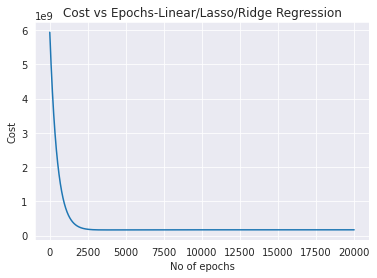

In [9]:
#Cost plot over epochs (1 value at end of each epoch) - over the last batch
sns.set_style('darkgrid')
ax = sns.lineplot(x=list(range(0,20001)),y=cost_history)
ax.set(xlabel='No of epochs',ylabel='Cost',title='Cost vs Epochs-Linear/Lasso/Ridge Regression')

### UDF for predicting

In [10]:
def predict(w_,b_,test_x,test_y):
    
    print("Testing on :",test_x.shape[0],'rows')
    
    a_temp = fwd_prop(test_x,w_,b_) #Applying the trained weights(w_) and bias(b_)
    print('Shape of prediction :',a_temp.shape)
    
    print('MSE of test set :',mean_squared_error(test_y,a_temp))
    print('RMSE of test set :',np.sqrt(mean_squared_error(test_y,a_temp)))
    
    print(a_temp[0:3])
    
    return a_temp


# Predictions from the manual created linear regression model

In [11]:
predictions_ = predict(w_final,b_final,X_test_arr,y_test_arr)

Testing on : 147 rows
Shape of prediction : (147, 1)
MSE of test set : 8372257649.737726
RMSE of test set : 91500.04180183595
[[621722.14515856]
 [387168.1238044 ]
 [646401.60801532]]


# Linear Regression from sklearn as benchmark

In [12]:
from sklearn.linear_model import LinearRegression

#---------------------------------------------------------------------------------------
lin_reg = LinearRegression()
lin_reg.fit(X_arr,y_arr)

prediction_sklearn = lin_reg.predict(X_test_arr)

#---------------------------------------------------------------------------------------
print('MSE of test set :',mean_squared_error(y_test_arr,prediction_sklearn))
print('RMSE of test set :',np.sqrt(mean_squared_error(y_test_arr,prediction_sklearn)))

MSE of test set : 8372310378.628355
RMSE of test set : 91500.329937265


## Comparing the delta between manual predictions and sklearn predictions

In [13]:
delta = prediction_sklearn-predictions_

#---------------------------------------------------------
print('25th Quantile of delta :',np.quantile(delta,0.25))
print('Median of delta :',np.quantile(delta,0.5))
print('75th Quantile of delta :',np.quantile(delta,0.75))

25th Quantile of delta : 0.6008519925817382
Median of delta : 1.6480900684837252
75th Quantile of delta : 2.7984516001015436


# Checking the assumptions of linear regression

## Calculating the residuals

In [14]:
residuals = predictions_ - y_test_arr
residuals[0:3]

array([[   122.14515856],
       [ 34368.1238044 ],
       [-25598.39198468]])

## Assumption 1 : Linear relation between dependent & independent variable

-- Pair-plot for all the features on the whole data--


/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


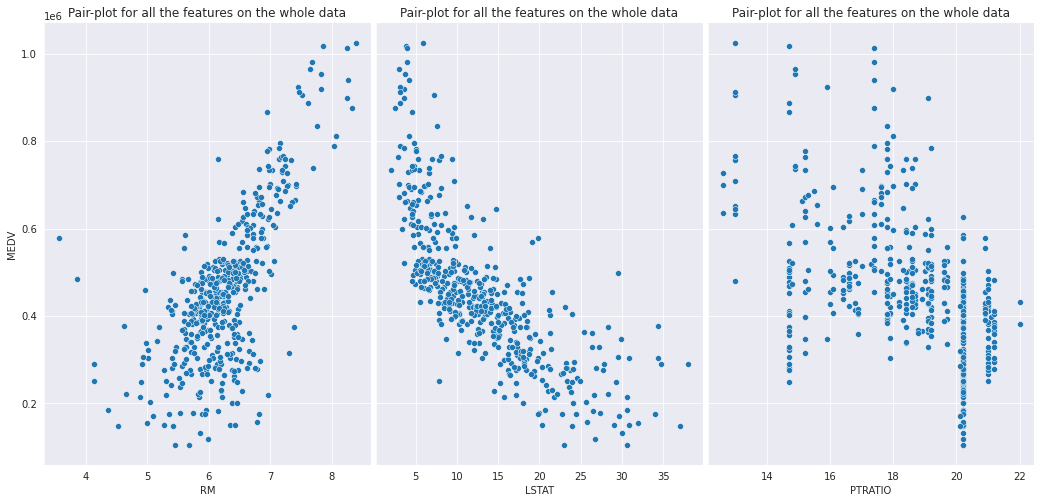

In [15]:
print('-- Pair-plot for all the features on the whole data--')
ax = sns.pairplot(input_ads,x_vars = ['RM','LSTAT','PTRATIO'],y_vars = ['MEDV'],size=7,aspect=0.7)
ax.set(title='Pair-plot for all the features on the whole data')

### Insights : 
1. We observe that RM and LSTAT have linear behaviour to some degree against the taget variable which aligns with the assumption of lineariy for linear regression

[Text(0.5, 0, 'Predicted-y in 1k units'),
 Text(0, 0.5, 'Residuals in 1k units'),
 Text(0.5, 1.0, 'Residuls vs Fitted Plot for Test Data')]

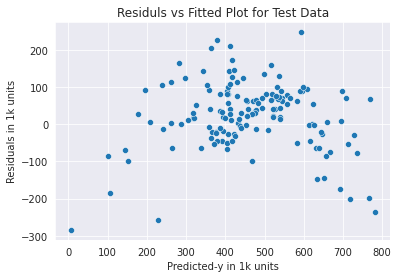

In [16]:
#Residual vs fitted plot for test data
sns.set_style("darkgrid")
ax = sns.scatterplot(x=np.divide(predictions_,1000).ravel(),y=np.divide(residuals,1000).ravel(),marker='o')
ax.set(xlabel='Predicted-y in 1k units', ylabel='Residuals in 1k units',title='Residuls vs Fitted Plot for Test Data')

### Insights - 
1. The above residual vs fitted plot is sowing very loose signs of a pattern which should be the case as the residuals shouldn't have any pattern among themselves as per the assumptions of linear regression  

## Assumption 2 : Mean of residulals should be close to 0

In [17]:
print('Mean of residuals (Should be 0):',np.mean(residuals))

Mean of residuals (Should be 0): 22875.82155499981


### Insights : 
1. Not abiding by the assumption

## Assumption 3 : Absence of Multi-Collinearity 

In [18]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

#------------------------------------------------------------------------------------
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

#------------------------------------------------------------------------------------
X_VIF = calc_vif(X)
X_VIF = X_VIF.sort_values(['VIF'],ascending=False) #Sorting by descending order
#X_VIF[X_VIF['VIF']>4] #Filtering for above 4 #Usually VIF above 4 or 5 is problematic
X_VIF

,variables,VIF
2,PTRATIO,57.754716
0,RM,42.446537
1,LSTAT,5.661858


### Insights : 
1. From above, we can see PTRATIO and RM have very high multi-collinearity, We'll have to validate this with correlation analysis

### Validating the above findings of VIF through pearson's correlation

<AxesSubplot:>

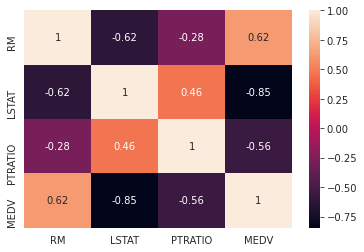

In [19]:
sns.set_style("darkgrid")
sns.heatmap(input_ads.corr(method='spearman'),annot=True)

## Assumption 4 : Homoskedascity check
### Definition : There residuals of the model should not be in any pattern

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 0, 'Predicted-y in 1k units'),
 Text(0, 0.5, 'Residuals in 1k units'),
 Text(0.5, 1.0, 'Residuls vs Fitted Plot for Test Data')]

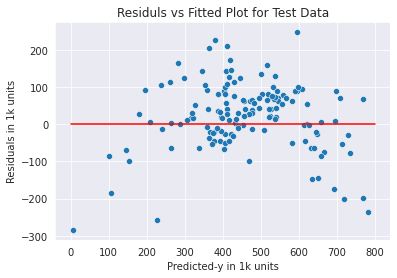

In [20]:
#Residual vs fitted plot for test data

sns.set_style("darkgrid")
ax = sns.scatterplot(x=np.divide(predictions_,1000).ravel(),y=np.divide(residuals,1000).ravel(),marker='o')
sns.lineplot([0,800],[0,0],color='red')
ax.set(xlabel='Predicted-y in 1k units', ylabel='Residuals in 1k units',title='Residuls vs Fitted Plot for Test Data')

### Hypothesis Test for Homoskedascity

In [21]:
import statsmodels.stats.api as sms
import statsmodels.api as sm
import pylab as py
from statsmodels.compat import lzip

#-------------------------------------------------------
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X_test)
lzip(name, test)

[('F statistic', 0.6222138265328544), ('p-value', 0.975810053228374)]

### Insights : 
1. From the plot, we can see theres no definite pattern suggesting no Heteroskedascity
2. From the hypothesis test above, we can see that p-value (~0.976) > alpha (0.05). Hence, we cannot reject the null hypothesis that there is homoskedascity present

## Assumption 5 : Normality of residuals

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


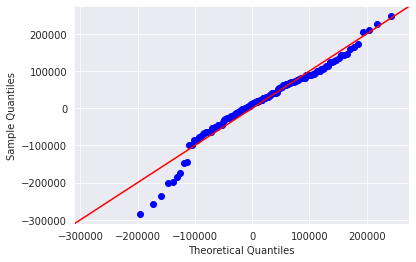

In [22]:
sm.qqplot(residuals.ravel(), line ='45', loc=np.mean(residuals.ravel()), scale=np.std(residuals.ravel()))
py.show()

### Insights : 
1. The residuals are fairly aligned with normal distribution with limited deviation at the initial quantiles

## Hypothesis testing to check for Gaussian spread of residuals

In [23]:
import scipy.stats as stats

#-----------------------------------------------------------
shap_stat,shap_p = stats.shapiro(residuals.ravel())
print('Stat :',shap_stat)
print('p-value from SHAPIRO_WILKS test :',shap_p)

Stat : 0.9606381058692932
p-value from SHAPIRO_WILKS test : 0.00032849362469278276


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

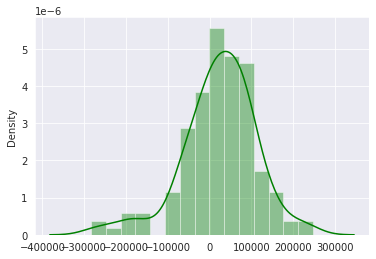

In [24]:
sns.distplot(residuals.ravel(),color='g')

### Insights : 
1. From the Q-Q plot, we could see that there was some minor deviation from normal distribution at the initial quantiles
2. From Shapiro-Wilks test we see that the p-value (~0.003) < alpha (0.05). Hence, we can reject the null hypothesis that the residual is normally distributed
3. From the kde-plot above, we can see that the distribution seems slightly left skewed (matching with initial quantiles of Q-Q plot)
4. All in all, the residuals are not normally distributed and hence the assumption is violated

# END